In [1]:
# Load up tidyverse and a path to Mikaela's data file
library(tidyverse)
path <- '/media/greg/jrn-DataProducts/JORNADA_IM/WIP_packages/210549002_soil_crust_physiology_(hoellrich)/'

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# Read in data (this is the one going to EDI)
df <- read.csv(paste0(path, 'JRN549002_Cfix_and_lightresponse.csv'))
# Name the rows with a unique id (makes kmeans a little easier)
df['trial_id'] <- paste0(df$Site, df$Type, df$Time, df$Rep)
row.names(df) <- df$trial_id

## Standardize C fixation columns

In [3]:
# Pull out the raw "PAR" columns with data for the photosynthetic response
# curves and append '_ns' to them (needed to split later)
parcols_bool <- grepl('PAR', names(df))
parcols <- names(df)[parcols_bool]
names(df)[parcols_bool] <- paste0(names(df)[parcols_bool], '_ns')

## Append standardized Cfixation (PAR) columns to dataframe
temp <- as.data.frame(df[,parcols_bool])
# Scale the data first (center by column means, scale to sd units)
temp <- as.data.frame(scale(temp))
names(temp) <- paste0(parcols, '_s') # add _s for standardized
# Add to dataframe
df <- cbind(df, temp)
head(df)
dim(df)

,Site,Type,Time,Rep,Thickness,Water,PercentWater,Cfix,Respiration,Net,⋯,PAR50_s,PAR100_s,PAR150_s,PAR300_s,PAR500_s,PAR750_s,PAR1000_s,PAR1250_s,PAR1600_s,PAR2000_s
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AMTCVLhalf1,AMT,CVL,half,1,9.26,0.7332,21.15407,7.989526,-8.344000,-0.354474,⋯,-0.6086247,-0.5194583,-0.5265578,-0.58630177,-0.4906061,-0.3116175,-0.2044845,-0.08759997,0.06536303,0.2788210
AMTCVLhalf2,AMT,CVL,half,2,12.37,1.1838,23.70919,10.316853,-15.412847,-5.095995,⋯,-2.7320208,-2.5527293,-2.4394029,-2.17940076,-1.9766014,-1.7193419,-1.5580908,-1.25343001,-1.06690806,-0.8865372
AMTCVLhalf3,AMT,CVL,half,3,7.64,0.7062,22.17965,7.617533,-10.059357,-2.441824,⋯,-1.3178655,-1.2062293,-0.8874285,-0.81104954,-0.6447645,-0.5140115,-0.3180336,-0.25627512,-0.20598819,-0.2583705
AMTCVLhalf4,AMT,CVL,half,4,7.28,0.6801,30.55256,6.258355,-10.873089,-4.614734,⋯,-1.6663704,-1.6068142,-1.3091309,-1.07402345,-1.0285496,-0.9559328,-0.8771790,-0.84465841,-0.87761138,-0.7682544
AMTCVLhalf5,AMT,CVL,half,5,8.25,0.8546,23.37527,3.026259,-9.555350,-6.529092,⋯,-1.1284596,-1.0803367,-1.1025934,-1.18027514,-1.2813023,-1.2604308,-1.2561381,-1.38186807,-1.32581413,-1.3273699
AMTCVLsix1,AMT,CVL,six,1,10.61,1.0072,22.65917,8.321375,-7.067911,1.253465,⋯,-0.3833420,-0.4396858,-0.2216901,0.05589145,0.1775508,0.3246528,0.5138203,0.48637808,0.68620494,0.6740159


[1] 499  37

## Reshape data, cluster, and plot

In [4]:
# Reshaping the data to long format with a standardized
# and raw Cfix column
dfx <- df  %>%
    pivot_longer(starts_with('PAR'),
                 names_to = c("PAR", ".value"),
                 names_pattern = "(.+)_(.+)") %>%
    mutate(PAR = as.numeric(substr(PAR, 4, 7))) %>%
    rename(Cfixation=ns, Cfixation_s=s)

head(dfx)


Site,Type,Time,Rep,Thickness,Water,PercentWater,Cfix,Respiration,Net,QuantumYield,SaturatingPPFD,trial_id,PAR,Cfixation,Cfixation_s
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>
AMT,CVL,half,1,9.26,0.7332,21.15407,7.989526,-8.344,-0.354474,0.0257603,2000,AMTCVLhalf1,0,-8.344000,-0.7730369
AMT,CVL,half,1,9.26,0.7332,21.15407,7.989526,-8.344,-0.354474,0.0257603,2000,AMTCVLhalf1,25,-7.684787,-0.6960966
AMT,CVL,half,1,9.26,0.7332,21.15407,7.989526,-8.344,-0.354474,0.0257603,2000,AMTCVLhalf1,50,-7.086395,-0.6086247
AMT,CVL,half,1,9.26,0.7332,21.15407,7.989526,-8.344,-0.354474,0.0257603,2000,AMTCVLhalf1,100,-6.288873,-0.5194583
AMT,CVL,half,1,9.26,0.7332,21.15407,7.989526,-8.344,-0.354474,0.0257603,2000,AMTCVLhalf1,150,-5.846585,-0.5265578
AMT,CVL,half,1,9.26,0.7332,21.15407,7.989526,-8.344,-0.354474,0.0257603,2000,AMTCVLhalf1,300,-5.360857,-0.5863018


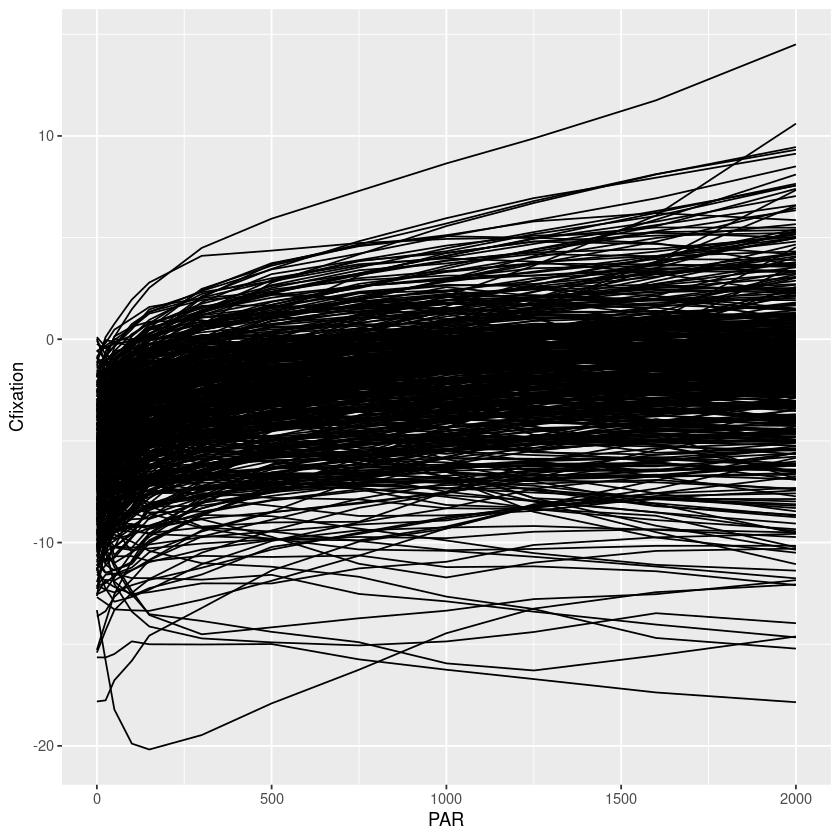

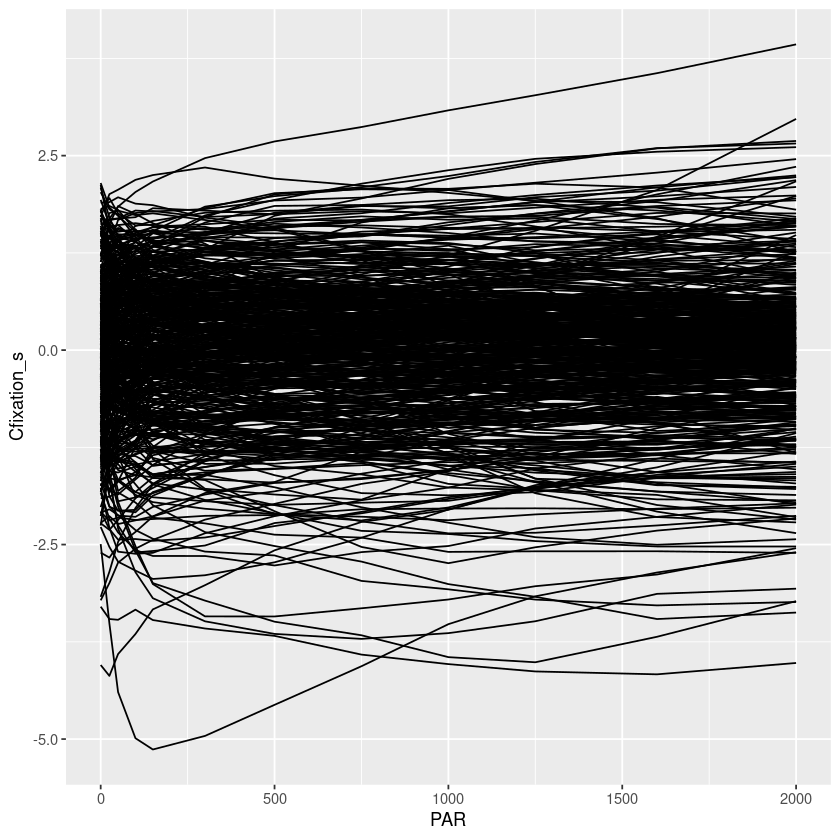

In [5]:
# Plot the reorged data so that we get a sense of how the
# photosynthetic response curves look 
g <- ggplot(dfx, aes(x=PAR, y=Cfixation, group=trial_id)) +
            geom_line()
g
# And standardized data
gs <- ggplot(dfx, aes(x=PAR, y=Cfixation_s, group=trial_id)) +
            geom_line()
gs

In [6]:
# Create dataframes with a standardized and non-standardized population
# to cluster with k means. Each row is a response curve
dfk <- df[,paste0(parcols, '_ns')]
dfk_s <- df[,paste0(parcols, '_s')]
head(dfk_s)

,PAR0_s,PAR25_s,PAR50_s,PAR100_s,PAR150_s,PAR300_s,PAR500_s,PAR750_s,PAR1000_s,PAR1250_s,PAR1600_s,PAR2000_s
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AMTCVLhalf1,-0.7730369,-0.6960966,-0.6086247,-0.5194583,-0.5265578,-0.58630177,-0.4906061,-0.3116175,-0.2044845,-0.08759997,0.06536303,0.2788210
AMTCVLhalf2,-3.2169998,-2.9942105,-2.7320208,-2.5527293,-2.4394029,-2.17940076,-1.9766014,-1.7193419,-1.5580908,-1.25343001,-1.06690806,-0.8865372
AMTCVLhalf3,-1.3660996,-1.4577376,-1.3178655,-1.2062293,-0.8874285,-0.81104954,-0.6447645,-0.5140115,-0.3180336,-0.25627512,-0.20598819,-0.2583705
AMTCVLhalf4,-1.5064240,-1.8009993,-1.6663704,-1.6068142,-1.3091309,-1.07402345,-1.0285496,-0.9559328,-0.8771790,-0.84465841,-0.87761138,-0.7682544
AMTCVLhalf5,-1.1918457,-1.1836828,-1.1284596,-1.0803367,-1.1025934,-1.18027514,-1.2813023,-1.2604308,-1.2561381,-1.38186807,-1.32581413,-1.3273699
AMTCVLsix1,-0.3290531,-0.4823187,-0.3833420,-0.4396858,-0.2216901,0.05589145,0.1775508,0.3246528,0.5138203,0.48637808,0.68620494,0.6740159


In [7]:
# Now run the K means clustering algorithm on the standardized data.
# The centers parameter tells the algorithm how many clusters to assign
# the population to

ncent <- 8 # number of centers

set.seed(20)
clusters_s <- kmeans(dfk_s, centers = ncent)

In [8]:
str(clusters_s)

List of 9
 $ cluster     : Named int [1:499] 1 4 7 7 8 6 7 6 2 2 ...
  ..- attr(*, "names")= chr [1:499] "AMTCVLhalf1" "AMTCVLhalf2" "AMTCVLhalf3" "AMTCVLhalf4" ...
 $ centers     : num [1:8, 1:12] -0.129 0.785 1.071 -1.87 0.129 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:8] "1" "2" "3" "4" ...
  .. ..$ : chr [1:12] "PAR0_s" "PAR25_s" "PAR50_s" "PAR100_s" ...
 $ totss       : num 5976
 $ withinss    : num [1:8] 105 203 135 164 114 ...
 $ tot.withinss: num 969
 $ betweenss   : num 5007
 $ size        : int [1:8] 93 132 54 22 66 43 49 40
 $ iter        : int 3
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [9]:
# A "quality check", i.e. what percentage of the total sum of squares is
# explained by the partition?
clusters_s$betweenss/clusters_s$totss * 100

# Now add the clusters back to the dataframe
df$cluster_s <- as.factor(clusters_s$cluster)

[1] 83.79192

In [10]:
# Lets do all that to un-scaled data for comparison too...
set.seed(20)
clusters <- kmeans(dfk, centers = ncent)
df$cluster <- as.factor(clusters$cluster)
# TotSS explained
clusters$betweenss/clusters$totss * 100
# How different are the 2 clustering results?
table(as.numeric(df$cluster) - as.numeric(df$cluster_s))

[1] 84.41075


 -6  -5  -1   0   2   3   4 
  1  23   4 444   1   9  17 

In [11]:
# Pivot again for plotting
dfx <- df  %>%
    pivot_longer(starts_with('PAR'),
                 names_to = c("PAR", ".value"),
                 names_pattern = "(.+)_(.+)") %>%
    mutate(PAR = as.numeric(substr(PAR, 4, 7))) %>%
    rename(Cfixation=ns, Cfixation_s=s)

tail(dfx)

Site,Type,Time,Rep,Thickness,Water,PercentWater,Cfix,Respiration,Net,QuantumYield,SaturatingPPFD,trial_id,cluster_s,cluster,PAR,Cfixation,Cfixation_s
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
WHS,PTL,two,5,7.06,0.7183,23.74545,5.560493,-4.97314,0.5873525,0.02197828,1600,WHSPTLtwo5,2,2,500,-0.89806742,0.6076428
WHS,PTL,two,5,7.06,0.7183,23.74545,5.560493,-4.97314,0.5873525,0.02197828,1600,WHSPTLtwo5,2,2,750,-0.03207247,0.7111068
WHS,PTL,two,5,7.06,0.7183,23.74545,5.560493,-4.97314,0.5873525,0.02197828,1600,WHSPTLtwo5,2,2,1000,0.17595930,0.6606540
WHS,PTL,two,5,7.06,0.7183,23.74545,5.560493,-4.97314,0.5873525,0.02197828,1600,WHSPTLtwo5,2,2,1250,0.37482193,0.6297597
WHS,PTL,two,5,7.06,0.7183,23.74545,5.560493,-4.97314,0.5873525,0.02197828,1600,WHSPTLtwo5,2,2,1600,0.58735248,0.5977718
WHS,PTL,two,5,7.06,0.7183,23.74545,5.560493,-4.97314,0.5873525,0.02197828,1600,WHSPTLtwo5,2,2,2000,0.49523644,0.4876606


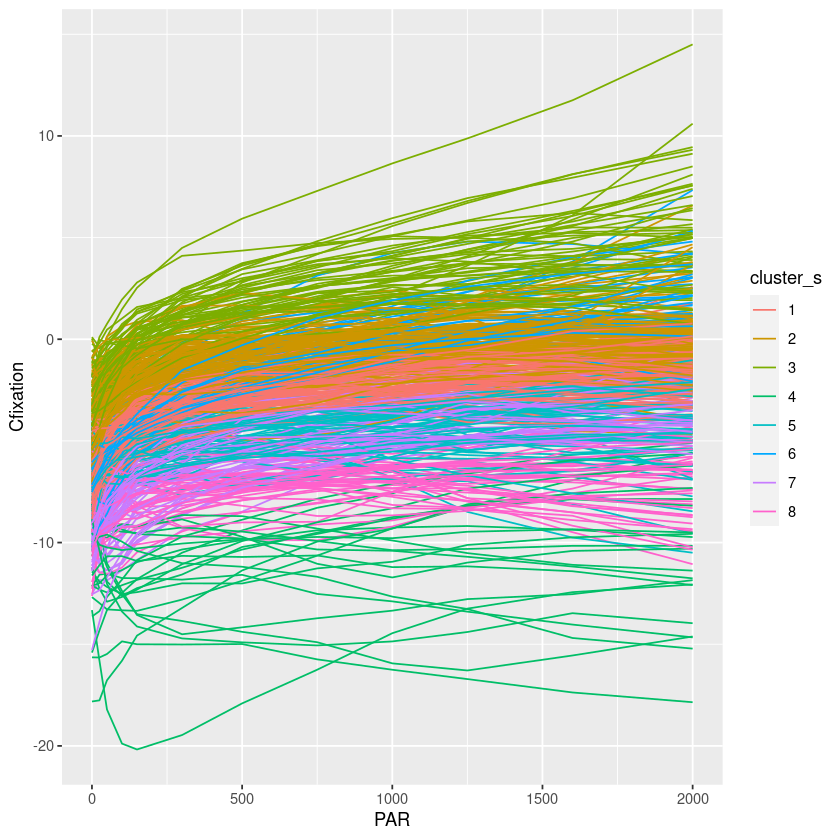

In [12]:
# Plot all the data and see how much the clusters overlap
g_s <- ggplot(dfx, aes(x=PAR, y=Cfixation, group=trial_id, color=cluster_s)) +
            geom_line()
g_s

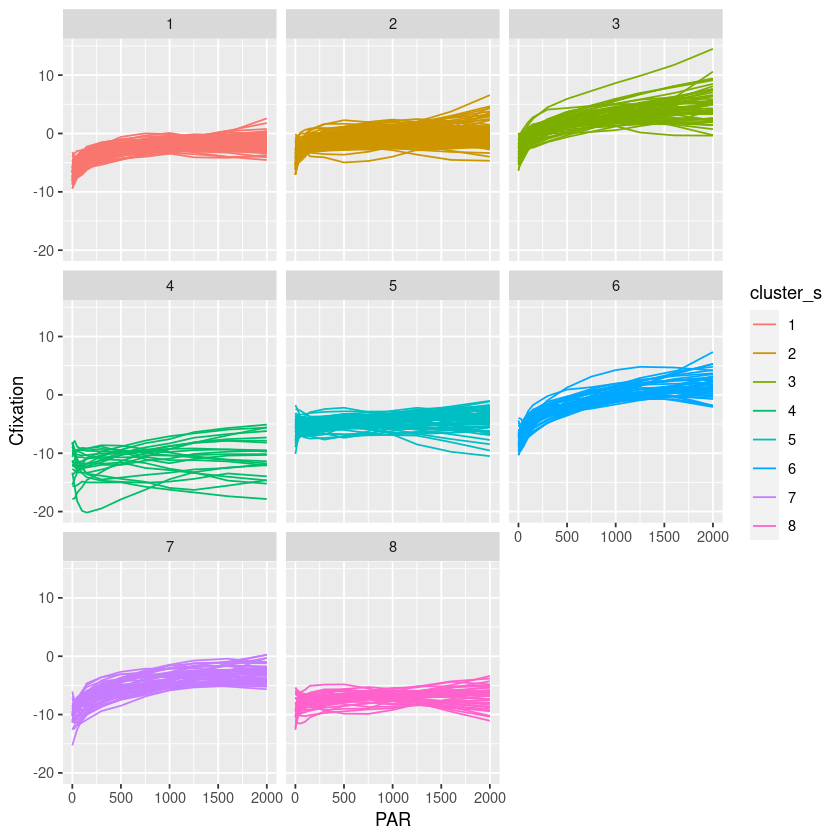

In [13]:
# Plot the clustered curves individually to see their general shapes
g_shapes_s <- ggplot(dfx, aes(x=PAR, y=Cfixation, group=trial_id, color=cluster_s)) +
    facet_wrap(vars(cluster_s)) + geom_line()
g_shapes_s
# and for non-standardized (for comparison later)
g_shapes <- ggplot(dfx, aes(x=PAR, y=Cfixation, group=trial_id, color=cluster)) +
    facet_wrap(vars(cluster)) + geom_line()
#g_shapes

The general shapes of the curve groups you can see above are pretty interesting - some might match with Mikaela's hypothesized curve shapes. To a point at least.

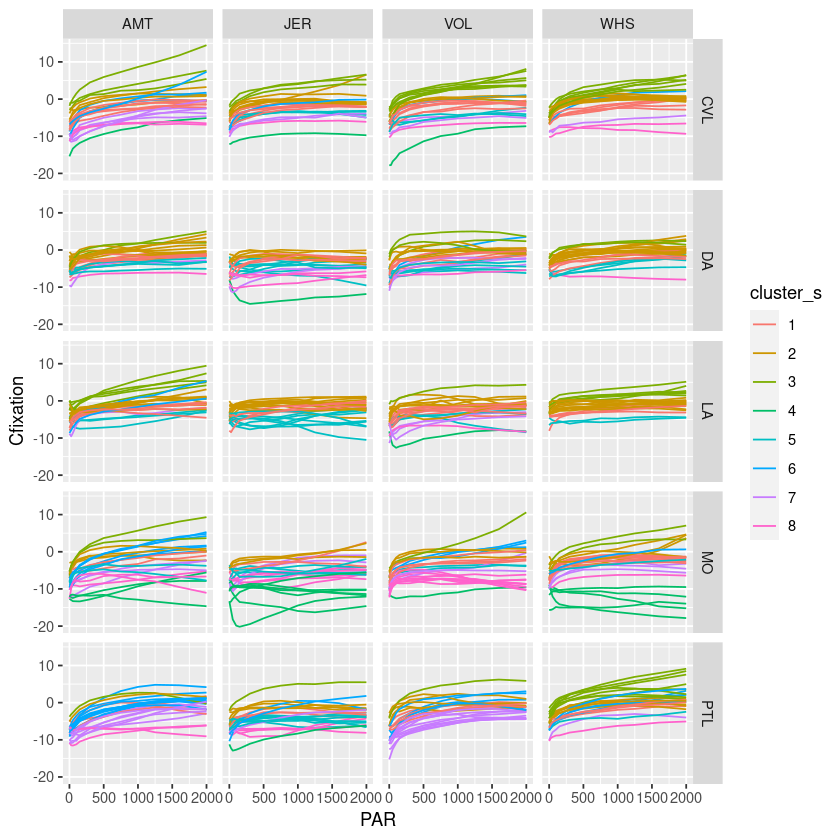

In [14]:
# Rough look at clustered curves by site and crust type
g_site_type_s <- ggplot(dfx, aes(x=PAR, y=Cfixation, group=trial_id, color=cluster_s)) +
    facet_grid(rows=vars(Type), cols=vars(Site)) + geom_line()
g_site_type_s
# and non standardized
g_site_type <- ggplot(dfx, aes(x=PAR, y=Cfixation, group=trial_id, color=cluster)) +
    facet_grid(rows=vars(Type), cols=vars(Site)) + geom_line()
#g_site_type

Hard to say if the curve clusters map very well to particular site X crust type combinations. Maybe a little.

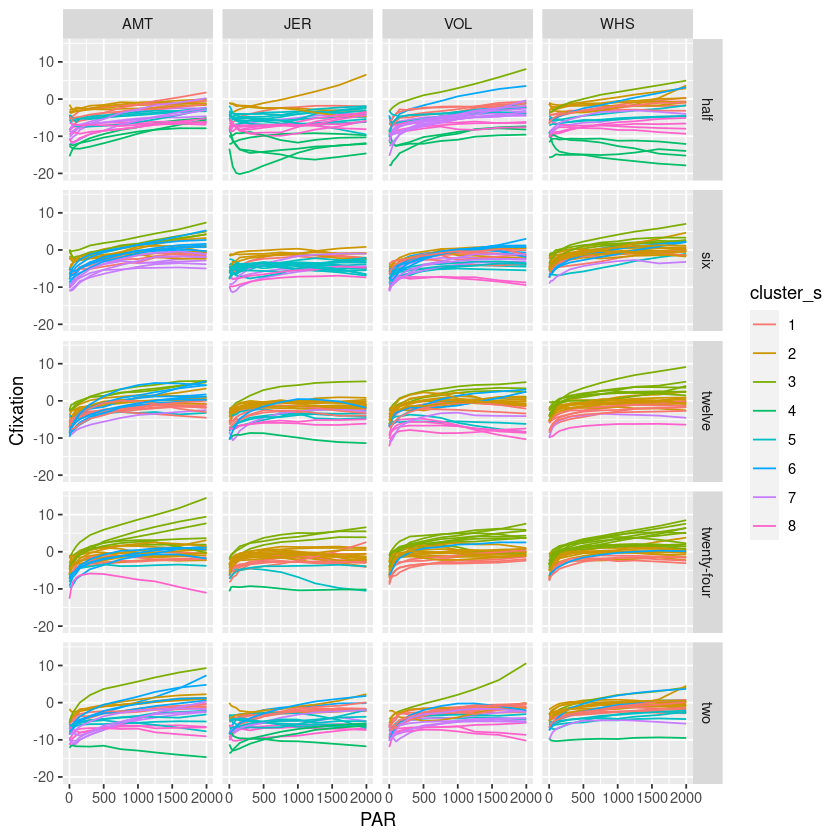

In [15]:
# Rough look at clustered curves by site and incubation time
g_site_time_s <- ggplot(dfx, aes(x=PAR, y=Cfixation, group=trial_id, color=cluster_s)) +
    facet_grid(rows=vars(Time), cols=vars(Site)) + geom_line()
g_site_time_s
# and non standardized
g_site_time <- ggplot(dfx, aes(x=PAR, y=Cfixation, group=trial_id, color=cluster)) +
    facet_grid(rows=vars(Time), cols=vars(Site)) + geom_line()
#g_site_time

Also hard to say if the curve clusters map to particular site X incubation time combinations. Maybe the more respiratory curve groups are more common early in incubations?

## Compare standardized and non-standardized clustering

In [16]:
library(cowplot)

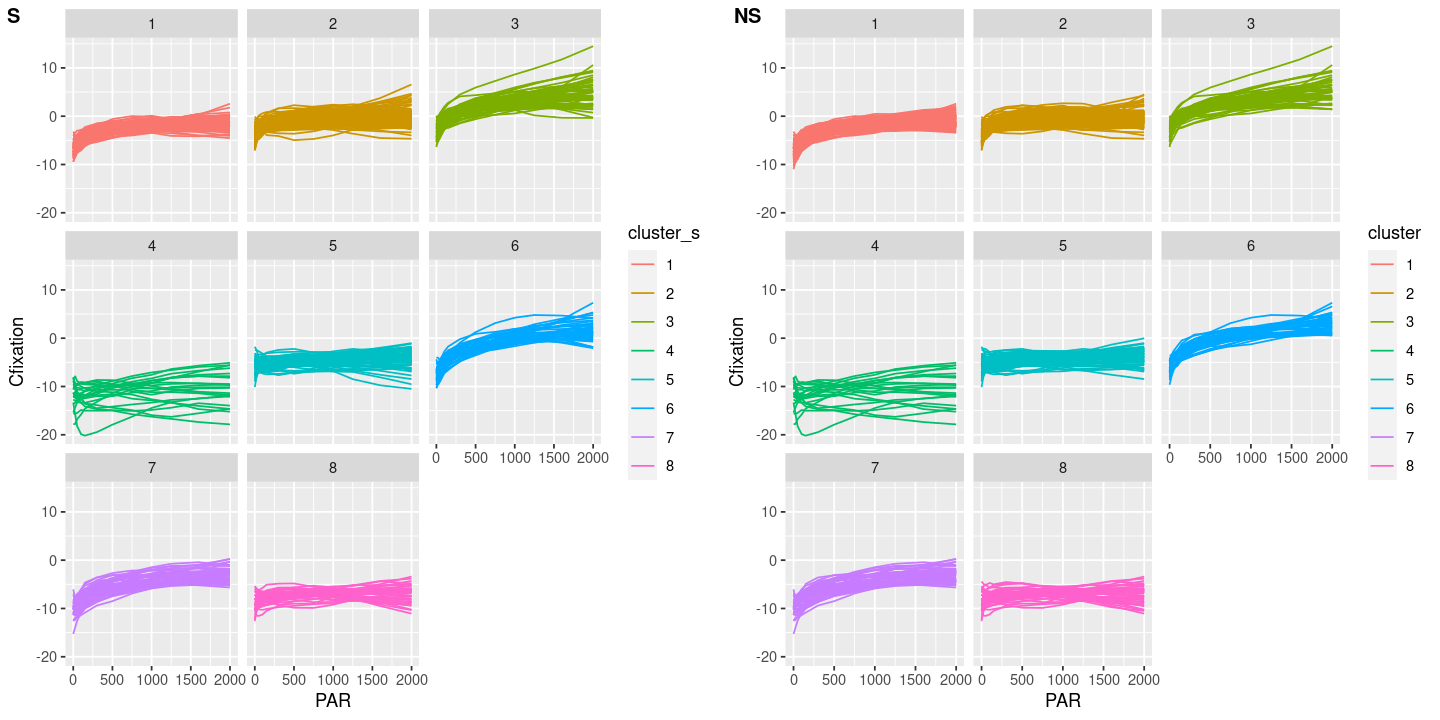

In [17]:
# Make a figure showing the 2 sets of clustered curves, standardized
# and non-standardized, together
options(repr.plot.width=12, repr.plot.height=6)
plot_grid(g_shapes_s, g_shapes, labels = c('S', 'NS'), label_size = 12)

Not sure if the standardization is doing much for us, but it could be useful to try the other dimensionality reducing techniques we discussed.